In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = '/content/drive/MyDrive/lampungaksara'

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

image = []
label = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/lampungaksara'):
    for filename in filenames:
        if filename.endswith('.png'):
            image.append(os.path.join(dirname, filename).split('/')[-1])
            label.append(os.path.join(dirname, filename).split('/')[-2])

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms as T
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import time
from torch.nn import functional as F
from torchvision import models
import torch.nn as nn
import torch
import random
import PIL

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
IMAGE_PATH = '/content/drive/MyDrive/lampungaksara/'

In [ ]:
df_full = pd.DataFrame({'image_id':image, 'label':label})

#FINDING BAD FILE

index = []
for i in range(len(df_full)):
    try:
        Image.open(IMAGE_PATH + str(df_full['label'].values[i]) + '/' + str(df_full['image_id'].values[i]))
    
    except PIL.UnidentifiedImageError:
        index.append(i)

df = df_full.drop(index)
df.head()

,image_id,label
0,ga0.png,ga
1,ga1.png,ga
2,ga2.png,ga
3,ga3.png,ga
4,ga4.png,ga


In [ ]:
label = ['ka', 'ga', 'nga', 'pa']

In [ ]:
label

['ka', 'ga', 'nga', 'pa']

In [ ]:
ints = np.arange(0, len(label))
dicts = dict(zip(label, ints))

In [ ]:
class lampungaksara(Dataset):
    def __init__(self, x, y, path, maps_label=dicts, transform=None):
        self.X = x
        self.y = y
        self.path = path
        self.dicts = maps_label
        self.transform = transform
        
    def __getitem__(self, idx):
        img = Image.open(self.path + str(self.y[idx]) + '/' + str(self.X[idx])).convert('RGB')
        label = self.y[idx]
        label = self.label_2_ints(label)
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, label
    
    def label_2_ints(self, x):
        label_id = None
        for key, values in self.dicts.items():
            if x == key:
                label_id = values
        return label_id
    
    def __len__(self):
        return len(self.X)

In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(df['image_id'].values, df['label'].values, 
                                                          test_size=0.15, stratify=df['label'].values, 
                                                          random_state=8)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, 
                                                  stratify=y_trainval, test_size=0.2,
                                                  random_state=8)
len(X_train), len(X_val), len(X_test)

(70, 18, 16)

In [ ]:
train_transform = T.Compose([T.Resize((128,128)),
                             T.RandomRotation((5, 30)),
                             T.RandomAffine((0,50)),
                             #T.RandomHorizontalFlip(),
                             T.RandomCrop(size=(100,100)), 
                             T.ToTensor()])

val_transform = T.Compose([T.Resize((128,128)),
                           #T.RandomHorizontalFlip(),
                           #T.RandomResizedCrop(size=(84,84)), 
                           T.ToTensor()])

train_set = lampungaksara(X_train, y_train, IMAGE_PATH, transform=train_transform)
val_set = lampungaksara(X_val, y_val, IMAGE_PATH, transform=val_transform)
test_set = lampungaksara(X_test, y_test, IMAGE_PATH, transform=val_transform)

BATCH_SIZE = 32
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

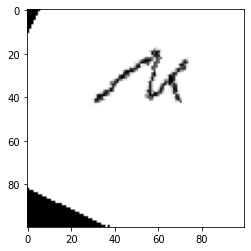

In [ ]:
img, label = train_set[random.randint(0, len(X_train))]

plt.imshow(img.permute(1,2,0))

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=20, bias=True)
#model.classifier[6] = nn.Linear(4096, 20)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def accuracy(output, label):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
epoch = 20
lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=epoch,
                                               steps_per_epoch=len(train_loader))

In [ ]:
train_losses = []
val_losses =[]
train_accuracy = []
val_acc = []
for e in range(epoch):
    model.to(device)
    model.train()
    
    train_loss = 0
    train_acc = 0
    since = time.time()
    for image, label in tqdm(train_loader, total=len(train_loader)):
        optimizer.zero_grad()
        
        image = image.to(device)
        label = label.to(device)
        
        output = model(image)
        loss = criterion(output, label)
        
        train_loss += loss
        train_acc += accuracy(output, label)
        
        loss.backward()
        optimizer.step()
        
        
        scheduler.step()
        
    else:
        with torch.no_grad():
            model.eval()
            
            running_loss = 0
            val_accuracy =0
            for image, label in val_loader:
                image = image.to(device)
                label = label.to(device)

                output = model(image)
                loss = criterion(output, label)
                val_accuracy += accuracy(output, label)
                running_loss += loss
                
    train_losses.append((train_loss/len(train_loader)).item())
    val_losses.append((running_loss/len(val_loader)).item())
    train_accuracy.append(train_acc/ len(train_loader))
    val_acc.append(val_accuracy/len(val_loader))
    
    print('epochs {}/{}..'.format(e+1, epoch),
          'train loss {:.3f}..'.format(train_loss/len(train_loader)),
          'val loss {:.3f}..'.format(running_loss/len(val_loader)),
          'train accuracy {:.3f}..'.format(train_acc/ len(train_loader)),
          'val accuracy {:.3f}..'.format(val_accuracy/len(val_loader)),
          'time {:.3f} s'.format(time.time() - since)
         )

  0%|          | 0/3 [00:00<?, ?it/s]

epochs 1/20.. train loss 2.950.. val loss 2.760.. train accuracy 0.031.. val accuracy 0.000.. time 10.503 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 2/20.. train loss 2.632.. val loss 2.623.. train accuracy 0.160.. val accuracy 0.111.. time 5.523 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 3/20.. train loss 1.606.. val loss 2.169.. train accuracy 0.545.. val accuracy 0.278.. time 5.457 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 4/20.. train loss 0.990.. val loss 1.523.. train accuracy 0.701.. val accuracy 0.500.. time 5.498 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 5/20.. train loss 0.720.. val loss 2.888.. train accuracy 0.816.. val accuracy 0.556.. time 5.616 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 6/20.. train loss 1.027.. val loss 1.009.. train accuracy 0.795.. val accuracy 0.667.. time 5.586 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 7/20.. train loss 0.525.. val loss 1.442.. train accuracy 0.875.. val accuracy 0.722.. time 5.588 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 8/20.. train loss 0.843.. val loss 6.110.. train accuracy 0.708.. val accuracy 0.333.. time 5.542 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 9/20.. train loss 0.416.. val loss 0.656.. train accuracy 0.806.. val accuracy 0.778.. time 5.566 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 10/20.. train loss 0.365.. val loss 1.928.. train accuracy 0.865.. val accuracy 0.722.. time 5.514 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 11/20.. train loss 0.409.. val loss 3.284.. train accuracy 0.885.. val accuracy 0.722.. time 5.546 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 12/20.. train loss 0.297.. val loss 0.137.. train accuracy 0.882.. val accuracy 0.944.. time 5.523 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 13/20.. train loss 0.207.. val loss 0.002.. train accuracy 0.924.. val accuracy 1.000.. time 5.439 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 14/20.. train loss 0.837.. val loss 0.003.. train accuracy 0.806.. val accuracy 1.000.. time 6.045 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 15/20.. train loss 0.446.. val loss 0.116.. train accuracy 0.872.. val accuracy 0.889.. time 5.476 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 16/20.. train loss 0.829.. val loss 0.450.. train accuracy 0.847.. val accuracy 0.889.. time 5.573 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 17/20.. train loss 0.686.. val loss 0.824.. train accuracy 0.826.. val accuracy 0.833.. time 5.488 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 18/20.. train loss 0.358.. val loss 0.834.. train accuracy 0.882.. val accuracy 0.833.. time 5.568 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 19/20.. train loss 0.472.. val loss 0.806.. train accuracy 0.806.. val accuracy 0.778.. time 5.557 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 20/20.. train loss 0.233.. val loss 0.627.. train accuracy 0.892.. val accuracy 0.833.. time 6.095 s


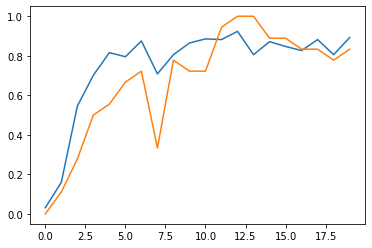

In [ ]:
plt.plot(train_accuracy)
plt.plot(val_acc)

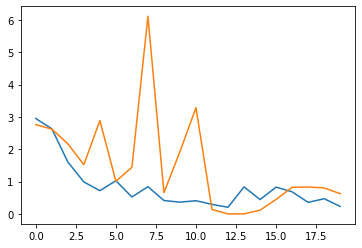

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)

In [ ]:
def predict(model, img, label):
    model.eval()
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)
        output = model(img)
        pred = torch.argmax(F.softmax(output, dim=1)).cpu().item()
    return pred

In [ ]:
test_predict = []
true_label = []
for i in range(len(test_set)):
    img, label = test_set[i]
    prediction = predict(model, img, label)
    test_predict.append(prediction)
    true_label.append(label)

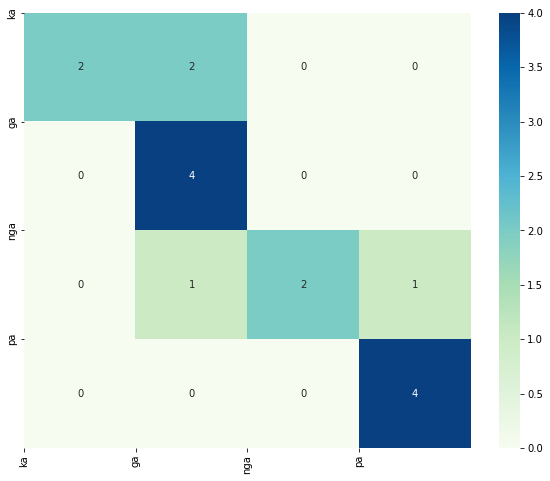

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(true_label, test_predict), annot=True, cmap='GnBu')
plt.xticks(ticks=np.arange(0, len(list(dicts.keys()))), labels = list(dicts.keys()), rotation=90)
plt.yticks(ticks=np.arange(0, len(list(dicts.keys()))), labels = list(dicts.keys()))
plt.show()

In [ ]:
print(classification_report(true_label, test_predict))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.57      1.00      0.73         4
           2       1.00      0.50      0.67         4
           3       0.80      1.00      0.89         4

    accuracy                           0.75        16
   macro avg       0.84      0.75      0.74        16
weighted avg       0.84      0.75      0.74        16



In [ ]:
label = ['ka', 'ga', 'nga', 'pa']
ints = np.arange(0, len(label))
dicts2 = dict(zip(ints, label))

def ints_2_label(x):
    label = None
    for key, values in dicts2.items():
        if x == key:
            label = values
    return label

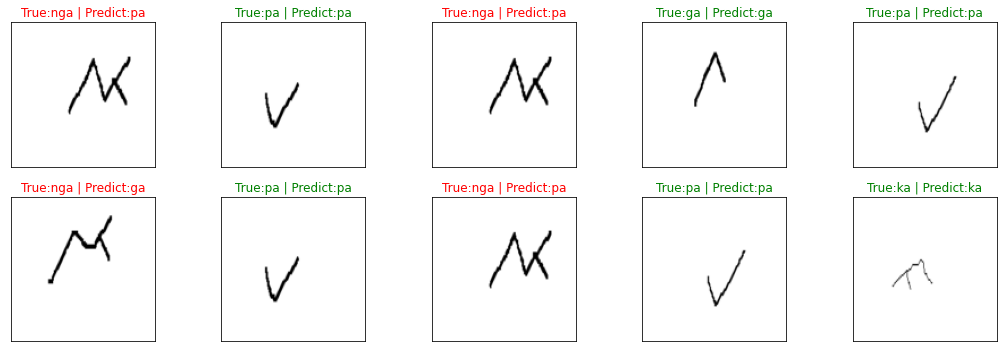

In [ ]:
random_selection = np.random.randint(0, len(test_predict), 10)

fig = plt.figure(figsize=(15, 5))

for i, idx in enumerate(random_selection):
    image, label = test_set[idx]
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks = [])
    ax.imshow(image.permute(1,2,0))
    ax.set_title('True:{} | Predict:{}'.format(ints_2_label(label), ints_2_label(test_predict[idx])),
                color=("green" if label == test_predict[idx] else 'red'), fontsize=12)

plt.tight_layout() #want faster comment or delete this
plt.show()